# Entropies of graph energies

In this experiment we are considering the entropy as the measure of [energy dispersion](https://goo.gl/qubCqh). There are multiple graph energies proposed in the literature, and in most cases the energy of a graph is defined as the sum of absolute values of eigenvalues of a particular matrix representing a graph. 

The energies computed in this experiment include:
* graph energy
* Randić energy
* Laplacian energy

Each of these energies describes a particular matrix, which in turn, expresses a different aspect of a graph. Below we present a brief overvue of each energy.

### graph energy

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).


### Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

### Laplacian energy

The Laplacian matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_L(i,j)=
\begin{cases}
d_i & \mathit{if} & i=j\\
-1 & \mathit{if} & i \neq j \; \& \; (i,j) \in E\\
0 & \mathit{otherwise} & 
\end{cases}
$$

Laplacian energy of a graph is defined as $E_L(G) = \sum\limits_{i=1}^n |\lambda_i-\frac{2m}{n}|$, where $\lambda_1, \ldots, \lambda_n$ are the eigenvalues of the Laplacian matrix $M_L$, $m=|E|$ is the number of edges, and $n=|V|$ is the number of nodes.


One can compute the energy of the entire graph, but this is of little use, since major variations may occur between different parts of the graph. In the experiment we compute local energies (energies of ego-networks for each node), thus obtaining a random variable representing all energy "states" of the graph. We then turn these into probability distributions and measure the entropy of each energy distribution. The assumption is that the entropy of energy distribution may reveal to which extent the energy is uniformly distributed across the network.

In the experiments below the following artificial network models are being used:
* Erdos-Renyi random graph model
* Watts-Strogatz small world graph model
* Waxman graph model
* Albert-Barabasi powerlaw graph model

For each network model we generate several instances of the model, modifying a single graph parameter (e.g., the random edge creation probability in the random graph model, or the edge rewiring probability in the small world graph model). Then, we compute all the energies of all ego-networks (of radius $r=1$) and we compute the entropy of the distribution of each energy.  

In [96]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [97]:
from tqdm import tqdm
from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats

from networkentropy import network_energy as ne

entropies = []

for p in tqdm(range(1,100)):

    generators = {
        'random': nx.erdos_renyi_graph(n=100, p=p/100),
        'smallworld': nx.watts_strogatz_graph(n=500, k=5, p=p/100),
        'waxman': nx.waxman_graph(n=100, alpha=p/100, beta=p/1000),
        'powerlaw': nx.powerlaw_cluster_graph(n=100, m=3, p=p/1000)
    }
    
    results = []

    for generator in generators.keys():
        
        G = generators[generator]
        
        for n in G.nodes:
            g = nx.ego_graph(G=G, n=n)

            E_randic = ne.get_randic_energy(g)
            E_graph = ne.get_graph_energy(g)
            E_laplace = ne.get_laplacian_energy(g)

            results.append((E_randic, E_graph, E_laplace))

        e_randic, e_graph, e_laplace = map(list, zip(*results))

        randic_cnt, _ = np.histogram(e_randic)
        graph_cnt, _ = np.histogram(e_graph)
        laplace_cnt, _ = np.histogram(e_laplace)

        randic_entropy = scipy.stats.entropy(randic_cnt)
        graph_entropy = scipy.stats.entropy(graph_cnt)
        laplace_entropy = scipy.stats.entropy(laplace_cnt)

        entropies.append((p, generator, randic_entropy, graph_entropy, laplace_entropy))

x, generator, y1, y2, y3 = map(list, zip(*entropies))

df = pd.DataFrame({'x':x, 'generator': generator, 'randic': y1, 'graph': y2, 'laplace': y3})

100%|██████████| 99/99 [08:08<00:00,  4.94s/it]


In [120]:
dfm = pd.melt(df, id_vars=['x','generator'], value_vars=['graph','laplace','randic'])

## Results

Below we present the preliminary results. Not only does the entropy change for each graph model, but there are visible differences between the models as well.

1. **Powerlaw graph model** : when the probability of triad closure in the powerlaw graph model is low, the entropy tends to increase, but after reaching a certain saturation point the entropy of most energies begins to steadily decrease 

2. **Random graph model** : entropies of all energies quickly increase and stay at the maximum level during the densification of the graph, when the edge probability creation reaches 1 (leading to a large clique), the entropies drop.

3. **Small world**: we begin with a regular small world lattice and gradually increase the probability of edge rewiring. Interestingly, the addition of random edges affects the entropies only at the beginning, but after a certain threshold the entropy begins to diminish

4. **Waxman**: the behavior of entropies is very similar to the small world network, despite the fact that the generative model is significantly different.

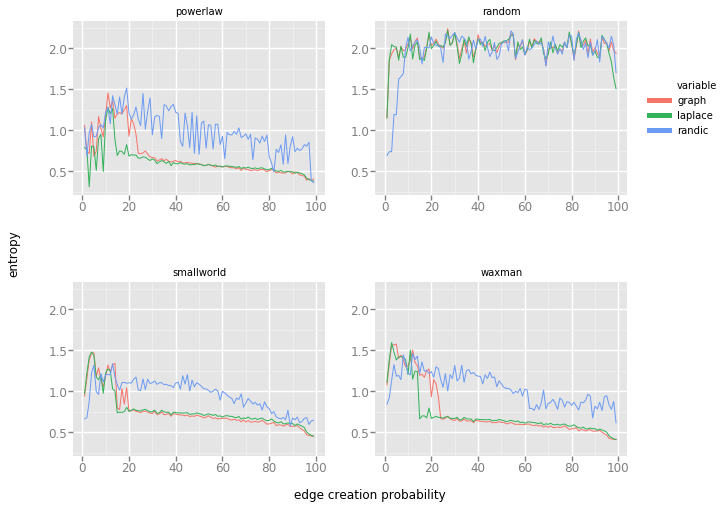

<ggplot: (-9223363251300192445)>

In [121]:
ggplot(aes(x='x', y='value', color='variable'), data=dfm) + \
geom_line() + \
facet_wrap('generator') + \
ylab('entropy') + \
xlab('edge creation probability')